# NLP Standard Project:

- Students: **Matteo Belletti**, **Alessandro Pasi**, **Stricescu Razvan Ciprian**.

In [ ]:
!pip install datasets==2.13.2
!pip install accelerate -U
!pip install evaluate

In [2]:
!pip install --upgrade transformers

     ---------------------------------------- 0.0/126.8 kB ? eta -:--:--
     -------------------------------------- 126.8/126.8 kB 3.6 MB/s eta 0:00:00
  Using cached tokenizers-0.15.0-cp310-none-win_amd64.whl.metadata (6.8 kB)
   ---------------------------------------- 0.0/8.2 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.2 MB 8.9 MB/s eta 0:00:01
   -- ------------------------------------- 0.6/8.2 MB 7.4 MB/s eta 0:00:02
   ---- ----------------------------------- 0.9/8.2 MB 7.2 MB/s eta 0:00:02
   ----- ---------------------------------- 1.2/8.2 MB 7.0 MB/s eta 0:00:02
   ------- -------------------------------- 1.5/8.2 MB 6.8 MB/s eta 0:00:01
   -------- ------------------------------- 1.8/8.2 MB 6.8 MB/s eta 0:00:01
   ---------- ----------------------------- 2.1/8.2 MB 6.7 MB/s eta 0:00:01
   ----------- ---------------------------- 2.4/8.2 MB 6.7 MB/s eta 0:00:01
   ------------- -------------------------- 2.7/8.2 MB 6.6 MB/s eta 0:00:01
   -------------- 


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from tqdm import tqdm
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.dummy import DummyClassifier
import pandas as pd
import json
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, accuracy_score, f1_score
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Device: {device}")

d:\NLProject\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


## Data loading and preprocessing:

In [2]:
# open json in project_data_MELD folder
try:
    with open('project_data_MELD/MELD_train_efr.json') as f:
        data = json.load(f)
except:
    with open('MELD_train_efr.json') as f:
        data = json.load(f)
print(f"Number of samples: {len(data)}")
print(f"Example of a sample: {data[0]}")

Number of samples: 4000
Example of a sample: {'episode': 'utterance_0', 'speakers': ['Chandler', 'The Interviewer', 'Chandler', 'The Interviewer', 'Chandler'], 'emotions': ['neutral', 'neutral', 'neutral', 'neutral', 'surprise'], 'utterances': ["also I was the point person on my company's transition from the KL-5 to GR-6 system.", "You must've had your hands full.", 'That I did. That I did.', "So let's talk a little bit about your duties.", 'My duties?  All right.'], 'triggers': [0.0, 0.0, 0.0, 1.0, 0.0]}


In [3]:
# Convert data to pandas dataframe
df = pd.DataFrame(data)
# drop episode and speakers columns
df = df.drop(columns=['episode'])
print(f"Dataframe shape: {df.shape}")
print(f"Dataframe columns: {df.columns}")

Dataframe shape: (4000, 4)
Dataframe columns: Index(['speakers', 'emotions', 'utterances', 'triggers'], dtype='object')


Changing nan values to zeros in order to avoid errors.

In [4]:
df["triggers"] = df["triggers"].apply(lambda x: [0 if elem != 1 and elem != 0 else elem for elem in x])
df["triggers"][3359]

[0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]

Splitting the data into train, validation and test sets with a 80-10-10 ratio.

In [5]:
# Split data
from sklearn.model_selection import train_test_split

df_train, temp = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(temp, test_size=0.5, random_state=42)

In [6]:
print(f"Train shape: {df_train.shape}")
print(f"Val shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (3200, 4)
Val shape: (400, 4)
Test shape: (400, 4)


As baselines models we need to implement a random model and a majority class model for emotions and triggers.

In [7]:
# first we create a dictionary of all emotions with their corresponding occurences
emotions_dict = {}
for emotions in df_train["emotions"]:
    for emotion in emotions:
        if emotion in emotions_dict:
            emotions_dict[emotion] += 1
        else:
            emotions_dict[emotion] = 1

# then we sort the dictionary by occurences
emotions_dict = {k: v for k, v in sorted(emotions_dict.items(), key=lambda item: item[1], reverse=True)}
print(emotions_dict)

{'neutral': 12066, 'joy': 4986, 'surprise': 3664, 'anger': 3203, 'sadness': 2108, 'fear': 889, 'disgust': 848}


Plotting the distribution of emotions could also be useful.

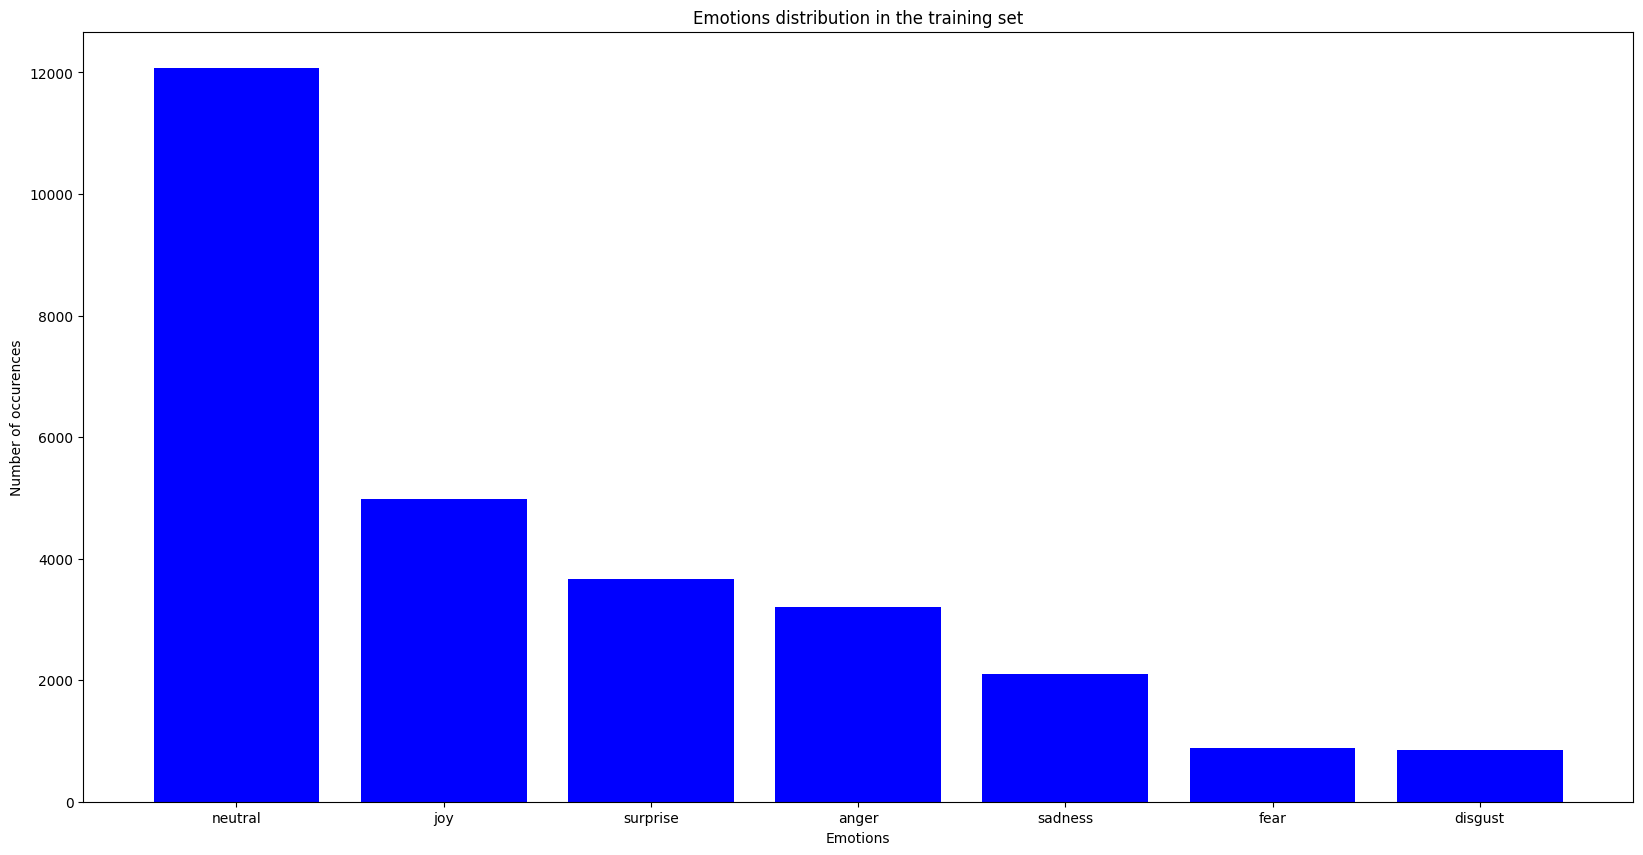

In [8]:
# plot the emotions distribution as histogram
plt.figure(figsize=(20,10))
plt.bar(emotions_dict.keys(), emotions_dict.values(), color='blue')
plt.title("Emotions distribution in the training set")
plt.xlabel("Emotions")
plt.ylabel("Number of occurences")
plt.show()

We can also implement some text processing techniques such as stemming, lemmatization, stop words removal, etc.

In this case we will use nltk library for lemmatization and stop words removal.

In [9]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
#stop_words = set(stopwords.words('english'))
bad_symbols = re.compile('[^a-z ]')
punct = string.punctuation

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ciprian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ciprian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ciprian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ciprian\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


We don't need to use lower case because we are going to use bert uncased models further on.

In [10]:
def preprocess_text(text):
    text = bad_symbols.sub('', text)
    text = word_tokenize(text)
    text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text

In [11]:
baseline_train = df_train.copy()
baseline_train["utterances"] = baseline_train["utterances"].apply(lambda x: [preprocess_text(elem) for elem in x])
baseline_test = df_test.copy()
baseline_test["utterances"] = baseline_test["utterances"].apply(lambda x: [preprocess_text(elem) for elem in x])
baseline_val = df_val.copy()
baseline_val["utterances"] = baseline_val["utterances"].apply(lambda x: [preprocess_text(elem) for elem in x])
print("Shape of train, val and test sets after preprocessing: ")
print(f"Train shape: {baseline_train.shape}")
print(f"Val shape: {baseline_val.shape}")
print(f"Test shape: {baseline_test.shape}")

Shape of train, val and test sets after preprocessing: 
Train shape: (3200, 4)
Val shape: (400, 4)
Test shape: (400, 4)


In order to use the TF-IDF vectorizer we need to split the utterances into single sentences, likewise the emotions and triggers.

In [12]:
def splitter(df, y_label):
    X = []
    y = []
    for index, row in df.iterrows():
        for i in range(len(row["utterances"])):
            X.append(row["utterances"][i])
            y.append(row[y_label][i])
    return X, y

In [13]:
# Emotions baseline
x_train_base, y_train_emotions = splitter(baseline_train, "emotions")
x_val_base, y_val_emotions = splitter(baseline_val, "emotions")
x_test_base, y_test_emotions = splitter(baseline_test, "emotions")

# Triggers baseline
_ , y_train_triggers = splitter(baseline_train, "triggers")
_ , y_val_triggers = splitter(baseline_val, "triggers")
_ , y_test_triggers = splitter(baseline_test, "triggers")

print(f"Train shape after splitting: {len(x_train_base)}")
print(f"Val shape after splitting: {len(x_val_base)}")
print(f"Test shape after splitting: {len(x_test_base)}")

Train shape after splitting: 27764
Val shape after splitting: 3678
Test shape after splitting: 3558


As a tokenizer we use TfidfVectorizer from sklearn.

In [14]:
vectorizer = TfidfVectorizer()

x_train_base = vectorizer.fit_transform(x_train_base)
x_val_base = vectorizer.transform(x_val_base)
x_test_base = vectorizer.transform(x_test_base)

print(f"Train shape after vectorization: {x_train_base.shape}")
print(f"Val shape after vectorization: {x_val_base.shape}")
print(f"Test shape after vectorization: {x_test_base.shape}")

print(f"Size of the vocabulary: {len(vectorizer.vocabulary_)}")

Train shape after vectorization: (27764, 5142)
Val shape after vectorization: (3678, 5142)
Test shape after vectorization: (3558, 5142)
Size of the vocabulary: 5142


Evaluation function that returns the classification report:

In [15]:
def evaluate(Y_test, Y_pred):
    report = classification_report(Y_test, Y_pred, zero_division=0)
    return report

Defining the dummy classifier for emotions and triggers:

In [16]:
dummy_clf_majority_emotions = DummyClassifier(strategy="most_frequent")
dummy_clf_random_emotions = DummyClassifier(strategy="uniform")

dummy_clf_majority_triggers = DummyClassifier(strategy="most_frequent")
dummy_clf_random_triggers = DummyClassifier(strategy="uniform")

Training and evaluation of the classifiers fitted on the training set:

In [17]:
# Emotions baseline
dummy_clf_majority_emotions.fit(x_train_base, y_train_emotions)
dummy_clf_random_emotions.fit(x_train_base, y_train_emotions)

y_pred_majority_emotions = dummy_clf_majority_emotions.predict(x_test_base)
y_pred_random_emotions = dummy_clf_random_emotions.predict(x_test_base)
print("Majority classifier for emotions: \n")
print(evaluate(y_test_emotions, y_pred_majority_emotions))
print("-------------------------------------------------------")
print("Random classifier for emotions: \n")
print(evaluate(y_test_emotions, y_pred_random_emotions))
print("-------------------------------------------------------")

# Triggers baseline
dummy_clf_majority_triggers.fit(x_train_base, y_train_triggers)
dummy_clf_random_triggers.fit(x_train_base, y_train_triggers)

y_pred_majority_triggers = dummy_clf_majority_triggers.predict(x_test_base)
y_pred_random_triggers = dummy_clf_random_triggers.predict(x_test_base)
print("Majority classifier for triggers: \n")
print(evaluate(y_test_triggers, y_pred_majority_triggers))
print("-------------------------------------------------------")
print("Random classifier for triggers: \n")
print(evaluate(y_test_triggers, y_pred_random_triggers))

Majority classifier for emotions: 

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       369
     disgust       0.00      0.00      0.00       101
        fear       0.00      0.00      0.00       109
         joy       0.00      0.00      0.00       663
     neutral       0.44      1.00      0.61      1572
     sadness       0.00      0.00      0.00       258
    surprise       0.00      0.00      0.00       486

    accuracy                           0.44      3558
   macro avg       0.06      0.14      0.09      3558
weighted avg       0.20      0.44      0.27      3558

-------------------------------------------------------
Random classifier for emotions: 

              precision    recall  f1-score   support

       anger       0.10      0.13      0.12       369
     disgust       0.04      0.18      0.06       101
        fear       0.03      0.14      0.05       109
         joy       0.19      0.14      0.16       663
     n

Bert

In [18]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
transformers.set_seed(RANDOM_SEED)

In [19]:
# get number of sentencese distribution
num_sentences = []
for index, row in df_train.iterrows():
    num_sentences.append(len(row["utterances"]))
print(f"Number of sentences distribution: {num_sentences}")
print(f"Max number of sentences: {max(num_sentences)}")

Number of sentences distribution: [9, 2, 3, 14, 4, 10, 8, 10, 19, 17, 4, 4, 6, 8, 10, 3, 9, 8, 22, 7, 9, 9, 12, 11, 7, 8, 4, 4, 8, 8, 5, 7, 14, 12, 7, 3, 8, 4, 13, 10, 13, 9, 3, 4, 14, 16, 5, 3, 11, 11, 3, 6, 5, 3, 15, 4, 6, 13, 7, 10, 7, 3, 4, 5, 22, 19, 8, 9, 8, 8, 3, 15, 6, 9, 6, 12, 3, 6, 19, 5, 7, 11, 6, 5, 4, 17, 6, 3, 3, 6, 12, 14, 4, 14, 5, 14, 14, 6, 4, 8, 4, 12, 18, 3, 5, 4, 4, 14, 12, 4, 5, 3, 11, 3, 10, 5, 13, 8, 5, 10, 10, 9, 6, 3, 9, 14, 9, 7, 5, 15, 16, 3, 9, 21, 4, 17, 6, 12, 9, 6, 10, 12, 2, 6, 9, 17, 17, 8, 15, 12, 24, 4, 16, 14, 19, 4, 4, 11, 4, 4, 8, 9, 19, 16, 6, 8, 4, 2, 8, 4, 8, 9, 15, 18, 19, 5, 18, 5, 14, 11, 5, 6, 5, 11, 3, 16, 5, 16, 10, 8, 3, 16, 8, 11, 20, 8, 10, 5, 4, 11, 16, 4, 9, 14, 8, 14, 8, 13, 4, 2, 10, 7, 14, 5, 6, 5, 6, 11, 15, 11, 5, 3, 6, 9, 3, 7, 6, 8, 8, 19, 6, 8, 3, 9, 6, 4, 4, 3, 9, 5, 8, 5, 8, 8, 7, 12, 16, 9, 9, 3, 4, 5, 9, 7, 18, 3, 3, 14, 10, 5, 4, 2, 4, 6, 3, 10, 8, 7, 6, 3, 5, 5, 8, 3, 8, 7, 5, 12, 7, 21, 6, 16, 10, 15, 4, 13, 12, 8, 8,

In [20]:
bert_train = df_train.copy()
bert_val = df_val.copy()
bert_test = df_test.copy()

In [21]:
# chain utterances in one sentence while also adding the speaker + plus change emotions to numeric 
'''
def chain_utterances(df):
    # add column to df
    df_copy = df.copy()

    for i in range(len(df["utterances"])):
        speakers = []
        sentence = ""
        for j in range(len(df.iloc[i]["utterances"])):
            df_copy.iloc[i]["emotions"][j] = df.iloc[i]["emotions"][j] + str(int(df.iloc[i]["triggers"][j]))
    return df_copy
'''

'\ndef chain_utterances(df):\n    # add column to df\n    df_copy = df.copy()\n\n    for i in range(len(df["utterances"])):\n        speakers = []\n        sentence = ""\n        for j in range(len(df.iloc[i]["utterances"])):\n            df_copy.iloc[i]["emotions"][j] = df.iloc[i]["emotions"][j] + str(int(df.iloc[i]["triggers"][j]))\n    return df_copy\n'

In [22]:
'''
columns = ["speakers", "emotions", "utterances", "triggers"]

def splitter_bert(df):
    temp = pd.DataFrame(columns=columns)
    for i in range(df.shape[0]):
        for j, _ in enumerate(df.iloc[i]['speakers']):
            new_row = pd.DataFrame({'speakers': [df.iloc[i]['speakers']],
                        'emotions': [df.iloc[i]['emotions'][:j+1]],
                        'utterances': [df.iloc[i]['utterances']],
                        'triggers': [df.iloc[i]['triggers'][:j+1]]})
            temp = pd.concat([temp, new_row], ignore_index=True)
    return temp
'''

'\ncolumns = ["speakers", "emotions", "utterances", "triggers"]\n\ndef splitter_bert(df):\n    temp = pd.DataFrame(columns=columns)\n    for i in range(df.shape[0]):\n        for j, _ in enumerate(df.iloc[i][\'speakers\']):\n            new_row = pd.DataFrame({\'speakers\': [df.iloc[i][\'speakers\']],\n                        \'emotions\': [df.iloc[i][\'emotions\'][:j+1]],\n                        \'utterances\': [df.iloc[i][\'utterances\']],\n                        \'triggers\': [df.iloc[i][\'triggers\'][:j+1]]})\n            temp = pd.concat([temp, new_row], ignore_index=True)\n    return temp\n'

In [23]:
def splitter_bert(df):
    columns = ["label", "sentence", "trigger"]
     # split the utteracnes into sentences with their corresponding labels
    new_df = pd.DataFrame(columns=columns)
    for index, row in df.iterrows():
        for i in range(len(row["utterances"])):
            new_row = pd.DataFrame({"label": [row["emotions"][i]], "sentence": [row["utterances"][i]], "trigger": [row["triggers"][i]]})
            new_df = pd.concat([new_df, new_row], ignore_index=True)
    return new_df

In [24]:
# split train, val and test sets for BERT
bert_train = splitter_bert(bert_train)
bert_val = splitter_bert(bert_val)
bert_test = splitter_bert(bert_test)
print("Shape of train, val and test sets after splitting: ")
print(f"Train shape: {bert_train.shape}")
print(f"Val shape: {bert_val.shape}")
print(f"Test shape: {bert_test.shape}")
print("-------------------------------------------------------")
print("Example of a sample: ")
print(bert_train.iloc[0])

C:\Users\Ciprian\AppData\Local\Temp\ipykernel_16716\2463025762.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, new_row], ignore_index=True)
C:\Users\Ciprian\AppData\Local\Temp\ipykernel_16716\2463025762.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, new_row], ignore_index=True)
C:\Users\Ciprian\AppData\Local\Temp\ipykernel_16716\2463025762.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is 

Shape of train, val and test sets after splitting: 
Train shape: (27764, 3)
Val shape: (3678, 3)
Test shape: (3558, 3)
-------------------------------------------------------
Example of a sample: 
label       neutral
sentence       Hey.
trigger         0.0
Name: 0, dtype: object


In [49]:
bert_train.head()

,label,sentence,trigger
0,neutral,Hey.,0.0
1,joy,Hey!,0.0
2,neutral,So how was Joan?,0.0
3,neutral,I broke up with her.,0.0
4,surprise,"Don't tell me, because of the big nostril thing?",0.0


In [25]:
# one hot encode the emotions
emotions_one_hot_dict = {
    "neutral": [1, 0, 0, 0, 0, 0, 0],
    "joy": [0, 1, 0, 0, 0, 0, 0],
    "surprise": [0, 0, 1, 0, 0, 0, 0],
    "sadness": [0, 0, 0, 1, 0, 0, 0],
    "anger": [0, 0, 0, 0, 1, 0, 0],
    "disgust": [0, 0, 0, 0, 0, 1, 0],
    "fear": [0, 0, 0, 0, 0, 0, 1]
}

In [104]:
# one hot encode the triggers
triggers_one_hot_dict = {
    0: [1, 0],
    1: [0, 1]
}

In [26]:
emotion_to_index = {
    "neutral": 0,
    "joy": 1,
    "surprise": 2,
    "sadness": 3,
    "anger": 4,
    "disgust": 5,
    "fear": 6
}

In [27]:
# get max length of sentences
max_len = 0
for sentence in bert_train["sentence"]:
    if len(sentence) > max_len:
        max_len = len(sentence)
print(f"Max length of sentences: {max_len}")

Max length of sentences: 327


In [43]:
MODEL_NAME = 'bert-base-uncased'
#MODEL_NAME = "prajjwal1/bert-tiny"

MAX_LEN = 360
BATCH_SIZE = 1
EPOCHS = 3
LEARNING_RATE = 2e-05
OUT_CHANNELS = 768 if "base" in  MODEL_NAME else 128 #128 if "tiny" 1024 if "base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [105]:
class CustomDataset(Dataset):

    def __init__(self, data, tokenizer, max_len, test_flag = False):
        self.tokenizer = tokenizer
        self.data = data
        self.text = data.sentence
        self.emotions = data.label
        self.max_len = max_len
        self.test_flag = test_flag
        self.triggers = data.trigger

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        #speakers = row["speakers"]
        text = row["sentence"]
        emotions = row["label"]
        trigger = row["trigger"]
        target_emotion = emotions_one_hot_dict[emotions] #+ [triggers[-1]] # trigger is float while emotions are one hot encoded but as integers IN CASE OF ERROR CHECK THIS
        target_trigger = triggers_one_hot_dict[trigger]


        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'label': torch.tensor(target_emotion, dtype=torch.float),
            'trigger': torch.tensor(target_trigger, dtype=torch.float)
        }

In [106]:
train_dataset = CustomDataset(bert_train, tokenizer, MAX_LEN)
val_dataset = CustomDataset(bert_val, tokenizer, MAX_LEN, test_flag=True)
test_dataset = CustomDataset(bert_test, tokenizer, MAX_LEN, test_flag=True)

# Definiition of the Dataloader that will feed the data in batches to the neural network for suitable training and processing.
training_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [107]:
train_dataset[0]

{'input_ids': tensor([ 101, 4931, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0, 

In [108]:
class BERTClass(torch.nn.Module):
    def __init__(self,model):
        super(BERTClass, self).__init__()
        self.l1 = transformers.AutoModel.from_pretrained(model, return_dict=False)
        # Emotions
        self.l2 = torch.nn.Dropout(p=0.3)
        self.l3 = torch.nn.Linear(OUT_CHANNELS, 7)
        # Triggers
        self.l4 = torch.nn.Dropout(p=0.3)
        self.l5 = torch.nn.Linear(OUT_CHANNELS, 2)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_emotions = self.l2(output_1)
        output_emotions = self.l3(output_emotions)
        output_trigger = self.l4(output_1)
        output_trigger = self.l5(output_trigger)
        return output_emotions, output_trigger

In [109]:
model = BERTClass(MODEL_NAME)
'''
for name, param in model.named_parameters():
     if name.startswith("l1"): # choose whatever you like here
        param.requires_grad = False
'''
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [110]:
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)
    
    f1 = f1_score(y_pred=predictions, y_true=labels, average='macro')
    acc = accuracy_score(y_pred=predictions, y_true=labels)
    return {'f1': f1, 'acc': acc}

In [111]:
#compute class weights based on distribution of classes in training set
from sklearn.utils import class_weight
y_train = []
for index, row in df_train.iterrows():
    for i in range(len(row["utterances"])):
        y_train.append(row["emotions"][i])
class_weights_emotions = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
print(f"Class weights: {class_weights_emotions}")
class_weights_emotions = torch.tensor(class_weights_emotions, dtype=torch.float)

Class weights: [1.23830338 4.67722372 4.46151374 0.7954845  0.32871587 1.88153971
 1.08250156]


In [112]:
y_train = []
for index, row in df_train.iterrows():
    for i in range(len(row["utterances"])):
        y_train.append(row["triggers"][i])
class_weights_triggers = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
print(f"Class weights: {class_weights_triggers}")
class_weights_triggers = torch.tensor(class_weights_triggers, dtype=torch.float)

Class weights: [0.59643394 3.09244821]


In [113]:
def compute_loss(output_emotion, output_trigger, targets_emotion, targets_trigger):
    label_emotion = targets_emotion
    label_trigger = targets_trigger
    # compute custom loss 
    loss_fct_emo = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights_emotions).to(device))
    loss = loss_fct_emo(output_emotion, label_emotion)
    loss_fct_targ = torch.nn.BCEWithLogitsLoss(weight=torch.tensor(class_weights_triggers).to(device))
    loss += loss_fct_targ(output_trigger, label_trigger)
    return loss

In [114]:
optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=(0.1*(len(training_loader))*EPOCHS), num_training_steps=len(training_loader)*EPOCHS)

In [118]:
def train():
    size = len(training_loader.dataset)
    model.train()
    for batch,data in enumerate(training_loader, 0):
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        target_emotion = data['label'].to(device, dtype = torch.float)
        target_trigger = data['trigger'].to(device, dtype = torch.float)
        
        output_emotion, output_trigger = model(ids, mask, token_type_ids)
        #loss = loss_fn(outputs, targets)
        loss = compute_loss(output_emotion, output_trigger, target_emotion, target_trigger)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if batch%1000==0:
            current =  batch * len(data['input_ids'])
            print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

In [119]:
def validation(epoch, val_loss_min_input):
    num_batches = len(val_loader)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch, data in enumerate(val_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            target_emotion = data['label'].to(device, dtype = torch.float)
            target_trigger = data['trigger'].to(device, dtype = torch.float)

            output_emotion, output_target = model(ids, mask, token_type_ids)
            val_loss += compute_loss(output_emotion, output_target, target_emotion, target_trigger).item()

        val_loss /= num_batches
        #outputs, targets = fin_outputs, fin_targets
        print(f"\nValidation loss: {val_loss:>8f}.")
        ## TODO: save the model if validation loss has decreased
        if val_loss <= val_loss_min_input:
            #create checkpoint variable and add important data
            if epoch > 0:
                print('Validation loss decreased ({:.8f} --> {:.8f}).  Saving model ...'.format(val_loss_min_input, val_loss))
            else: print('Saving model ...')
            # save best moel
            torch.save(model.state_dict(), "model_bert_standard_project.pth")
            print("Saved PyTorch Model State to model.pth\n")
            val_loss_min_input = val_loss

    return val_loss_min_input

In [ ]:
val_loss_min_st = np.inf
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train()
    val_loss_min_st = validation(epoch, val_loss_min_st)

In [126]:
def inference(model, test_load):
    model.eval()
    fin_targets_emotion = []
    fin_outputs_emotion = []
    fin_targets_trigger = []
    fin_outputs_trigger = []

    with torch.no_grad():
        for batch, data in enumerate(test_load, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            target_emotion = data['label'].to(device, dtype = torch.float)
            target_trigger = data['trigger'].to(device, dtype = torch.float)

            output_emotion, output_trigger = model(ids, mask, token_type_ids)
            fin_targets_emotion.extend(torch.argmax(target_emotion, axis=1).cpu().detach().numpy().tolist())
            fin_outputs_emotion.extend(torch.argmax(output_emotion, axis=1).cpu().detach().numpy().tolist())
            fin_targets_trigger.extend(target_trigger.cpu().detach().numpy().tolist())
            fin_outputs_trigger.extend(torch.sigmoid(output_trigger).cpu().detach().numpy().tolist())
        
    return fin_outputs_emotion, fin_targets_emotion, fin_outputs_trigger, fin_targets_trigger


In [127]:
outputs_emotion, targets_emotion, outputs_trigger, targets_trigger = inference(model, test_loader)

In [130]:
def get_threshold(targets, outputs):
    results = {}
    for tr in np.arange(0.1, 0.9, 0.1):
        tr = round(tr, 2)
        predictions= np.array(outputs) >= tr
        results[tr] = f1_score(targets, predictions, average='macro')
    return max(results, key=results.get)

In [132]:
th = get_threshold(targets_trigger, outputs_trigger)
print(f"Threshold: {th}")
predictions_trigger = np.array(outputs_trigger) >= th
report_triggers = classification_report(targets_trigger, predictions_trigger)
report_emotions = classification_report(targets_emotion, outputs_emotion, target_names=emotion_to_index.keys())
print("Report for triggers: \n")
print(report_triggers)
print("-------------------------------------------------------")
print("Report for emotions: \n")
print(report_emotions)

Threshold: 0.1
Report for triggers: 

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      3027
           1       0.15      0.99      0.26       531

   micro avg       0.50      1.00      0.67      3558
   macro avg       0.50      1.00      0.59      3558
weighted avg       0.75      1.00      0.82      3558
 samples avg       0.50      1.00      0.67      3558

-------------------------------------------------------
Report for emotions: 

              precision    recall  f1-score   support

     neutral       0.65      0.89      0.75      1572
         joy       0.58      0.55      0.57       663
    surprise       0.46      0.74      0.57       486
     sadness       0.00      0.00      0.00       258
       anger       0.00      0.00      0.00       369
     disgust       0.00      0.00      0.00       101
        fear       0.00      0.00      0.00       109

    accuracy                           0.60      3558
   macro avg  

d:\NLProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\NLProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\NLProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [105]:
import gc

model = None
del model

with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

9